# A1: Data Curation

In [1]:
import json
import requests

## Step 1: Data acquisition

We use two WIkimedia API endpoints:

1. Legacy pagecounts API
2. Pageviews API

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
legacy_desktop_params={"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"}
legacy_mobile_params={"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"}
pageviews_desktop_params={"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2021100100'}
pageviews_mobile_app_params={"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2021100100'}
pageviews_mobile_web_params={"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2021100100'}
headers = {
    'User-Agent': 'https://github.com/Minerva-Lan',
    'From': 'lluan@uw.edu'
}

In [4]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

In [5]:
legacy_desktop_monthly = api_call(endpoint_legacy, legacy_desktop_params)
legacy_mobile_monthly = api_call(endpoint_legacy, legacy_mobile_params)

In [6]:
with open('pagecounts_desktop-site_200712-201607.json', 'w') as file:
    json.dump(legacy_desktop_monthly, file)
with open('pagecounts_mobile-site_200712-201607.json', 'w') as file:
    json.dump(legacy_mobile_monthly, file)

In [7]:
pageviews_desktop_monthly =api_call(endpoint_pageviews, pageviews_desktop_params)
pageviews_mobile_app_monthly =api_call(endpoint_pageviews, pageviews_mobile_app_params)
pageviews_mobile_web_monthly =api_call(endpoint_pageviews, pageviews_mobile_web_params)

In [8]:
with open('pageviews_desktop_201507-202109.json', 'w') as file:
    json.dump(pageviews_desktop_monthly, file)
with open('pageviews_mobile-app_201507-202109.json', 'w') as file:
    json.dump(pageviews_mobile_app_monthly, file)
with open('pageviews_mobile-web_201507-202109.json', 'w') as file:
    json.dump(pageviews_mobile_web_monthly, file)

## Step 2: Data processing

In [9]:
from collections import defaultdict
import pandas as pd
from functools import reduce

In [10]:
def read_json_file(filename):
    data ={}
    with open(filename, 'r') as f:
        data=json.loads(f.read())
    return data

In [11]:
pagecounts_desktop_views = read_json_file('pagecounts_desktop-site_200712-201607.json')
pagecounts_mobile_views =read_json_file('pagecounts_mobile-site_200712-201607.json')

pageviews_desktop_views = read_json_file('pageviews_desktop_201507-202109.json')
pageviews_mobile_app_views = read_json_file('pageviews_mobile-app_201507-202109.json')
pageviews_mobile_web_views = read_json_file('pageviews_mobile-web_201507-202109.json')

In [12]:
def yyyymm(timestamp):
    return str(timestamp[:4]) + str(timestamp[4:6]).rjust(2, "0")

In [13]:
desktop_views_pagecounts = defaultdict(int)
mobile_views_pagecounts =defaultdict(int)

desktop_views_pageviews = defaultdict(int)
mobile_views_pageviews = defaultdict(int)

In [14]:
def create_dic(data, dictionary):
    for item in data["items"]:
        key = yyyymm(item["timestamp"])
        if "views" in item:
            dictionary[key] +=item["views"]
        else:
            dictionary[key] +=item["count"]

In [15]:
create_dic(pagecounts_desktop_views, desktop_views_pagecounts)
create_dic(pagecounts_mobile_views, mobile_views_pagecounts)

create_dic(pageviews_desktop_views, desktop_views_pageviews)
create_dic(pageviews_mobile_app_views, mobile_views_pageviews)
create_dic(pageviews_mobile_web_views, mobile_views_pageviews)

In [16]:
def dic_to_df(dictionary, column_name):
    return pd.DataFrame({'yyyymm':list(dictionary.keys()), column_name: list(dictionary.values())})

In [17]:
pagecounts_desk_df = dic_to_df(desktop_views_pagecounts, 'pagecount_desktop_views')
pagecounts_mobile_df = dic_to_df(mobile_views_pagecounts, 'pagecount_mobile_views')

pageviews_desk_df = dic_to_df(desktop_views_pageviews, 'pageview_desktop_views')
pageviews_mobile_df = dic_to_df(mobile_views_pageviews, 'pageview_mobile_views')

In [18]:
def merge(df1, df2):
    return df1.merge(df2, on='yyyymm', how='outer')

all_df = reduce(merge, [pagecounts_desk_df, pagecounts_mobile_df, pageviews_desk_df, pageviews_mobile_df])

all_df.fillna(0, inplace=True)

In [19]:
all_df['pagecount_all_views'] = all_df['pagecount_desktop_views'] + all_df['pagecount_mobile_views']
all_df['pageview_all_views'] =all_df['pageview_desktop_views'] + all_df['pageview_mobile_views']

In [20]:
all_df.insert(0, "year", all_df.yyyymm.apply(lambda x: x[:4]))
all_df.insert(1, "month", all_df.yyyymm.apply(lambda x: x[4:6]))

In [21]:
all_df.drop('yyyymm', axis=1, inplace=True)

In [22]:
df_clean = all_df.reindex(['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
                          'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views'], axis =1)

In [23]:
df_clean.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


In [24]:
df_clean.to_csv('en-wikipedia_traffic_200712-202108.csv', index =False)

## Step 3: Analysis

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [26]:
path2data = 'en-wikipedia_traffic_200712-202108.csv'
df = pd.read_csv(path2data, parse_dates = {"date":["year", "month"]})
df.replace(0, np.nan, inplace=True)

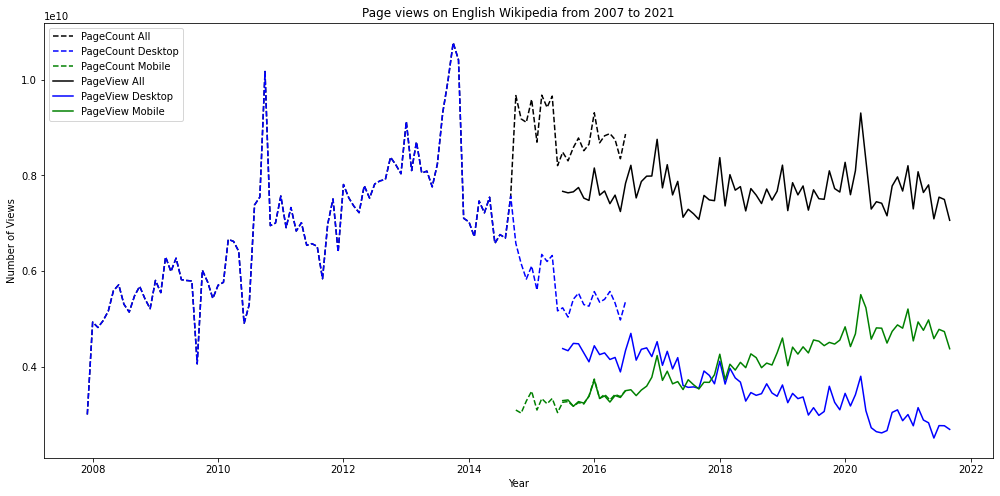

In [27]:
plt.figure(figsize=(17, 8))

plt.plot(df.date, df.pagecount_all_views, '--k')
plt.plot(df.date, df.pagecount_desktop_views, '--b')
plt.plot(df.date, df.pagecount_mobile_views, '--g')

plt.plot(df.date, df.pageview_all_views, '-k')
plt.plot(df.date, df.pageview_desktop_views, '-b')
plt.plot(df.date, df.pageview_mobile_views, '-g')

ymin, ymax = plt.ylim()

plt.legend(["PageCount All", "PageCount Desktop", "PageCount Mobile", 
            "PageView All", "PageView Desktop", "PageView Mobile"])

plt.title("Page views on English Wikipedia from 2007 to 2021")
plt.xlabel("Year")
plt.ylabel("Number of Views")
plt.show()